### Setup

In [76]:
# Importing custom python functions that will be used to run the example
from src.common import *
from src.data_processing import *
from src.fit import *
from src.utils import *

In [77]:
# Importing common python lybraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

### Users settings

In [78]:
# Define data set split between training and test sets
split_percent = 0.8
# Define data set sample size (in order to have flexibility to run faster experiments with some portion of the data)
sample_size = 86000
# PySindy and Simulation steps parameters
t0 = 1
dt = 1

### Describing the data and the problem

Our data set examples are real flow control loops from a steel making plant. We collected data from the PLC's (programmable logical controllers) in the shopflor in 2020, using a sample rate of 1 second.

We have data from two different control loops, which you can try to play with.

To remind yourself, PV is the Process Variable (flow measurement), CV is the Controlled Variable (PID controller output) and SP are the Set Point values.

The goal of use PySindy is to identify the process dynamics of a SISO (single input, single output) system, so that we can have a better understanding of the dynamics that govern the process. Althoug we usually model a flow loop as a FOPDT (first order plus dead time) model, we wanna use PySindy to further understand the full dynamic behavior of the system. 

We also have to remember that in real cases like this, the full dynamical system is governed by the process dynamics (air volumetric flow) + actuator dynamics (which is the control valve, typically a butterfly type of valve) + instrument dynamics (which is the flow sensor that uses differential pressure to measure flow) and finnally the closed loop PID controller dynamics.

Latter, we wanna try to use PySindy to model a MIMO (multiple input, multiple output) system, so that we can use a data-driven model identification approach and use the discovered model with a MPC controller.

### Loading data

In [79]:
# You can choose one of the two examples by changing example_1 boolean value.
# In this case, we will get data from the first flow control loop.
# Sample size allow you to determin how many samples you want to sample (total number of samples = 86401)
df = get_processed_data(example_1 = True, sample_size = sample_size)
print(df.shape)
df.head()

(86000, 3)


,PV,CV,SP
Timestamp,,,
2020-07-04 00:00:00,2251.958496,16.652611,2318.613770
2020-07-04 00:00:01,2251.958496,16.652611,2318.613770
2020-07-04 00:00:02,2252.810059,16.798349,2343.805908
2020-07-04 00:00:03,2252.810059,16.798349,2343.805908
2020-07-04 00:00:04,2240.823730,17.039141,2375.590088


Now that we have loaded the data that we need, we can now split into train and test sets, using the following function

For further details, please refer to the *data_processing.py* file

In [80]:

x_train, x_test, u_train, u_test, t_train = get_train_test_data(df, split_percent,sample_size,t0,dt)

### Data Understanding

Lets now plot training data to see its behavior

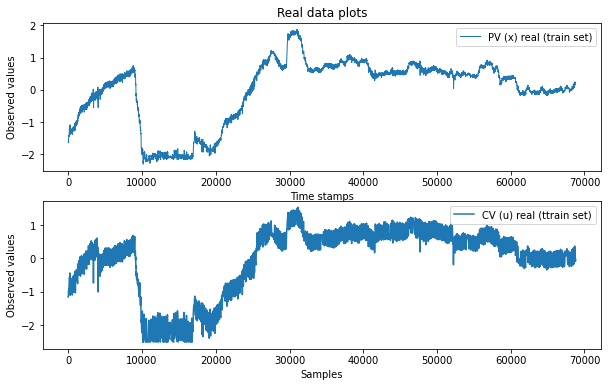

In [81]:
train_plots(u_train, x_train)

### Model Fit

Let's now use PySindy to try to find the dominant dynamics of full system as described before.

First, we are going to use PySindy without differentiation of the x values (which is the PV, which kind of represents the instrument + process dynamics)

We also preferred to model the system as a discrete system using STLSQ optimizer

In [82]:
(model_u_x) = fit_u_x(u_train, x_train, t_train, dt)
model_u_x.print()

(x)[k+1] = 0.995 x[k] + 0.006 u[k] + -0.005 x[k]^2 + 0.012 x[k] u[k] + -0.007 u[k]^2


Let's now use differentiation


In [83]:
(model_u_x_xdot, xdot) = fit_u_x_xdot(u_train, x_train, t_train, False, dt)
model_u_x_xdot.print()

(x)[k+1] = 1.000 x[k] + 0.985 xdot[k] + 0.103 x[k] xdot[k] + -1.494 xdot[k]^2 + -0.067 xdot[k] u[k]
(xdot)[k+1] = -0.002 x[k] + 0.743 xdot[k] + 0.002 u[k] + -0.001 x[k]^2 + 0.067 x[k] xdot[k] + 0.003 x[k] u[k] + 0.227 xdot[k]^2 + -0.090 xdot[k] u[k] + -0.002 u[k]^2


### Model simulation

Let's first simulate the model without differentiation. We will use test set data in order to see how the model generalizes.

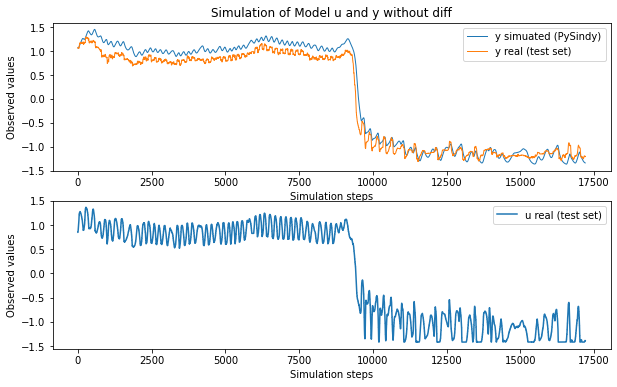

In [84]:
t_test = np.arange(0, u_test.shape[0], 1)
x0_test = np.array([x_test[0]])
X_test_sim_ux = model_u_x.simulate(x0_test, u=u_test, t=len(t_test))
simulate_plots(t_test, X_test_sim_ux, x_test, u_test, None)

In [85]:
# Test set metrics
# Mean absolute error
print("MAE",round(mae(x_test, X_test_sim_ux),3))

# Mean squared error
print("MSE",round(mse(x_test, X_test_sim_ux),3))

# R2 score
print("R2",round(r2(x_test, X_test_sim_ux),3))

MAE 0.151
MSE 0.033
R2 0.967


Let's now simulate the model with differentiation. We will also use the same test set data as before.

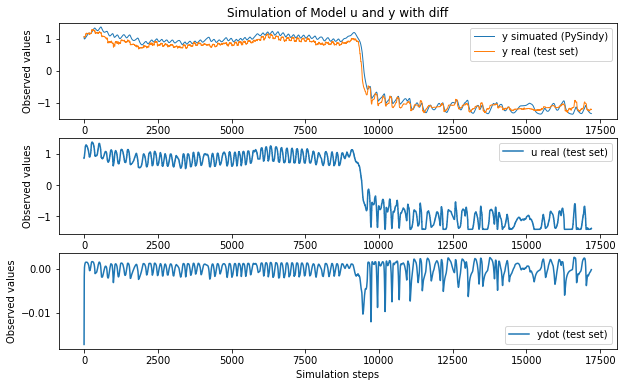

In [86]:
t_test = np.arange(0, u_test.shape[0], 1)
x0_test = np.array([x_test[0], xdot[-1]])


X_test_sim_ux_xdot = model_u_x_xdot.simulate(
    x0_test, u=u_test, t=len(t_test))
simulate_plots(t_test, X_test_sim_ux_xdot, x_test, u_test, xdot)

In [87]:
# Test set metrics
# Mean absolute error
print("MAE",round(mae(x_test, X_test_sim_ux_xdot[:, 0]),3))

# Mean squared error
print("MSE",round(mse(x_test, X_test_sim_ux_xdot[:, 0]),3))

# R2 score
print("R2",round(r2(x_test, X_test_sim_ux_xdot[:, 0]),3))

MAE 0.111
MSE 0.018
R2 0.982


In [94]:
# Calcuating performance difference between models
print("MAE diff",round(mae(x_test, X_test_sim_ux_xdot[:, 0])-mae(x_test, X_test_sim_ux),3))
print("MES diff",round(mse(x_test, X_test_sim_ux_xdot[:, 0])-mse(x_test, X_test_sim_ux),3))
print("R2 diff",round(r2(x_test, X_test_sim_ux_xdot[:, 0])-r2(x_test, X_test_sim_ux),3))

MAE diff -0.04
MES diff -0.015
R2 diff 0.015


### Conclusions


PySindy showed us that is capable to model real process control loop dynamics with great accuracy and it also give us a better understanding of the full dynamics present in the system. 

This inspire us to use the discrete version of the obtained ODEs to build a MIMO model and try to use a MPC controller to control the whole sytem.